# Loan Data from Prosper 
## by Christian Altmoos

## Preliminary Wrangling

This data set contains `113,937` loans with `81` variables on each loan, including loan amount, borrower rate (or interest rate), current loan status, borrower income, and many others. The dataset contains so-called listings which either have been transformed to a loan or not. Partially funded loans are possible as well. My main overall interest might be why and who is becoming a so-called Prosper borrower and furthermore is it attractive for Prosper lenders from a financial point of view.

In [2]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

In [4]:
# load the csv
df=pd.read_csv('prosperLoanData.csv')
# set the base color
base_color = sb.color_palette()[0]

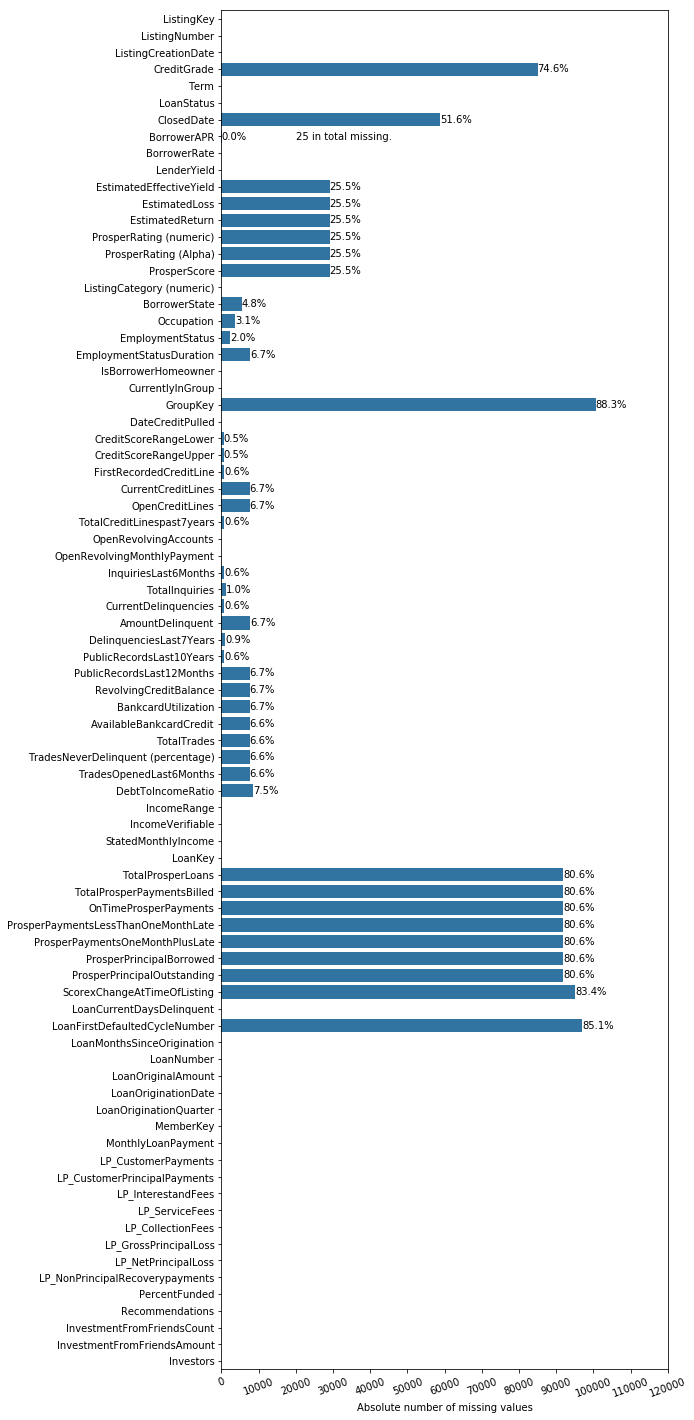

In [16]:
# as it is a huge dataset, let's visualize the missing data
# plot a horizontal bar chart 
null_counts = df.isnull().sum()
plt.figure(figsize=(8,25))
sb.barplot(x=null_counts, y=np.arange(len(null_counts)), orient = 'h', color=base_color)
plt.xlabel('Absolute number of missing values')
plt.xticks(np.arange(0,130000,10000), rotation=20)
plt.yticks(np.arange(len(null_counts)),null_counts.index,rotation='horizontal');

# annotate with %
for i in np.arange(len(null_counts)):
    prop = null_counts[i]/len(df)
    if prop > 0:
        pct_string = '{:0.1f}%'.format(100*prop)
        #print(pct_string)
        plt.text(null_counts[i]+1, i, pct_string, va = 'center')
# annotate a small number>        
plt.text(20000, 7, '25 in total missing.', va = 'center');

### What is the structure of your dataset?

The overall structure can be found in this Google Docs [Spreadsheet](https://docs.google.com/spreadsheets/d/1gDyi_L4UvIrLTEC6Wri5nbaMmkGmLQBk-Yx3z0XDEtI/edit). Some further useful information I foud here:
* Prosper API Description [link](https://www.prosper.com/Downloads/Services/Documentation/ProsperDataExport_Details.html)
* Information on expected data types [link](https://bigml.com/user/mrlender/gallery/dataset/512e7695035d075e7c0000be)
* Expalanation Listing [link](https://www.prosper.com/invest/how-to-invest/search-listings/)
* Some articles to build up basic doamin knowledge:
    * Review Prosper [link1](https://www.bankrate.com/loans/personal-loans/reviews/prosper/)
    * Peer 2 Peer Lending vs. Bank Loan [link2](https://www.bankrate.com/loans/personal-loans/peer-to-peer-lending-vs-bank-loan/)
* Some fed data for interest rates [link](https://fred.stlouisfed.org/categories/101)


* **ListingKey**:  Unique key for each listing, same value as the 'key' used in the listing object in the API.
* **ListingNumber**:  The number that uniquely identifies the listing to the public as displayed on the website.
* **ListingCreationDate**:  The date the listing was created.
* **CreditGrade**:  The Credit rating that was assigned at the time the listing went live. Applicable for listings pre-2009 period and will only be populated for those listings.
* **Term**:  The length of the loan expressed in months.
* **LoanStatus**:  The current status of the loan: Cancelled,  Chargedoff, Completed, Current, Defaulted, FinalPaymentInProgress, PastDue. The PastDue status will be accompanied by a delinquency bucket.
* **ClosedDate**:  Closed date is applicable for Cancelled, Completed, Chargedoff and Defaulted loan statuses. 
* **BorrowerAPR**:  The Borrower's Annual Percentage Rate (APR) for the loan.
* **BorrowerRate**:  The Borrower's interest rate for this loan. 
* **LenderYield**:  The Lender yield on the loan. Lender yield is equal to the interest rate on the loan less the servicing fee.
* **EstimatedEffectiveYield**:  Effective yield is equal to the borrower interest rate (i) minus the servicing fee rate, (ii) minus estimated uncollected interest on charge-offs, (iii) plus estimated collected late fees.  Applicable for loans originated after July 2009.
* **EstimatedLoss**:  Estimated loss is the estimated principal loss on charge-offs. Applicable for loans originated after July 2009.
* **EstimatedReturn**:  The estimated return assigned to the listing at the time it was created. Estimated return is the difference between the Estimated Effective Yield and the Estimated Loss Rate. Applicable for loans originated after July 2009.
* **ProsperRating (numeric)**:  The  Prosper Rating assigned at the time the listing was created: 0 - N/A, 1 - HR, 2 - E, 3 - D, 4 - C, 5 - B, 6 - A, 7 - AA.  Applicable for loans originated after July 2009.
* **ProsperRating (Alpha)**:  The Prosper Rating assigned at the time the listing was created between AA - HR.  Applicable for loans originated after July 2009.
* **ProsperScore**:  A custom risk score built using historical Prosper data. The score ranges from 1-10, with 10 being the best, or lowest risk score.  Applicable for loans originated after July 2009.
* **ListingCategory**:  The category of the listing that the borrower selected when posting their listing: 0 - Not Available, 1 - Debt Consolidation, 2 - Home Improvement, 3 - Business, 4 - Personal Loan, 5 - Student Use, 6 - Auto, 7- Other, 8 - Baby&Adoption, 9 - Boat, 10 - Cosmetic Procedure, 11 - Engagement Ring, 12 - Green Loans, 13 - Household Expenses, 14 - Large Purchases, 15 - Medical/Dental, 16 - Motorcycle, 17 - RV, 18 - Taxes, 19 - Vacation, 20 - Wedding Loans
* **BorrowerState**:  The two letter abbreviation of the state of the address of the borrower at the time the Listing was created.
* **Occupation**:  The Occupation selected by the Borrower at the time they created the listing.
* **EmploymentStatus**:  The employment status of the borrower at the time they posted the listing.
* **EmploymentStatusDuration**:  The length in months of the employment status at the time the listing was created.
* **IsBorrowerHomeowner**:  A Borrower will be classified as a homowner if they have a mortgage on their credit profile or provide documentation confirming they are a homeowner.
* **CurrentlyInGroup**:  Specifies whether or not the Borrower was in a group at the time the listing was created.
* **GroupKey**:  The Key of the group in which the Borrower is a member of. Value will be null if the borrower does not have a group affiliation.
* **DateCreditPulled**:  The date the credit profile was pulled. 
* **CreditScoreRangeLower**:  The lower value representing the range of the borrower's credit score as provided by a consumer credit rating agency.
* **CreditScoreRangeUpper**:  The upper value representing the range of the borrower's credit score as provided by a consumer credit rating agency. 
* **FirstRecordedCreditLine**:  The date the first credit line was opened.
* **CurrentCreditLines**:  Number of current credit lines at the time the credit profile was pulled.
* **OpenCreditLines**:  Number of open credit lines at the time the credit profile was pulled.
* **TotalCreditLinespast7years**:  Number of credit lines in the past seven years at the time the credit profile was pulled.
* **OpenRevolvingAccounts**:  Number of open revolving accounts at the time the credit profile was pulled.
* **OpenRevolvingMonthlyPayment**:  Monthly payment on revolving accounts at the time the credit profile was pulled.
* **InquiriesLast6Months**:  Number of inquiries in the past six months at the time the credit profile was pulled.
* **TotalInquiries**:  Total number of inquiries at the time the credit profile was pulled.
* **CurrentDelinquencies**:  Number of accounts delinquent at the time the credit profile was pulled.
* **AmountDelinquent**:  Dollars delinquent at the time the credit profile was pulled.
* **DelinquenciesLast7Years**:  Number of delinquencies in the past 7 years at the time the credit profile was pulled.
* **PublicRecordsLast10Years**:  Number of public records in the past 10 years at the time the credit profile was pulled.
* **PublicRecordsLast12Months**:  Number of public records in the past 12 months at the time the credit profile was pulled.
* **RevolvingCreditBalance**:  Dollars of revolving credit at the time the credit profile was pulled.
* **BankcardUtilization**:  The percentage of available revolving credit that is utilized at the time the credit profile was pulled.
* **AvailableBankcardCredit**:  The total available credit via bank card at the time the credit profile was pulled.
* **TotalTrades**:  Number of trade lines ever opened at the time the credit profile was pulled.
* **TradesNeverDelinquent**:  Number of trades that have never been delinquent at the time the credit profile was pulled.
* **TradesOpenedLast6Months**:  Number of trades opened in the last 6 months at the time the credit profile was pulled.
* **DebtToIncomeRatio**:  The debt to income ratio of the borrower at the time the credit profile was pulled. This value is Null if the debt to income ratio is not available. This value is capped at 10.01 (any debt to income ratio larger than 1000% will be returned as 1001%).
* **IncomeRange**:  The income range of the borrower at the time the listing was created.
* **IncomeVerifiable**:  The borrower indicated they have the required documentation to support their income.
* **StatedMonthlyIncome**:  The monthly income the borrower stated at the time the listing was created.
* **LoanKey**:  Unique key for each loan. This is the same key that is used in the API. 
* **TotalProsperLoans**:  
* **TotalProsperPaymentsBilled**:  Number of on time payments the borrower made on Prosper loans at the time they created this listing. This value will be null if the borrower had no prior loans.
* **OnTimeProsperPayments**:  Number of on time payments the borrower had made on Prosper loans at the time they created this listing. This value will be null if the borrower has no prior loans.
* **ProsperPaymentsLessThanOneMonthLate**:  Number of payments the borrower made on Prosper loans that were less than one month late at the time they created this listing. This value will be null if the borrower had no prior loans. 
* **ProsperPaymentsOneMonthPlusLate**:  Number of payments the borrower made on Prosper loans that were greater than one month late at the time they created this listing. This value will be null if the borrower had no prior loans.
* **ProsperPrincipalBorrowed**:  Total principal borrowed on Prosper loans at the time the listing was created. This value will be null if the borrower had no prior loans.
* **ProsperPrincipalOutstanding**:  Principal outstanding on Prosper loans at the time the listing was created. This value will be null if the borrower had no prior loans.
* **ScorexChangeAtTimeOfListing**:  Borrower's credit score change at the time the credit profile was pulled. This will be the change relative to the borrower's last Prosper loan. This value will be null if the borrower had no prior loans.
* **LoanCurrentDaysDelinquent**:  The number of days delinquent. 
* **LoanFirstDefaultedCycleNumber**:  The cycle the loan was charged off. If the loan has not charged off the value will be null. 
* **LoanMonthsSinceOrigination**:  Number of months since the loan originated.
* **LoanNumber**:  Unique numeric value associated with the loan.
* **LoanOriginalAmount**:  The origination amount of the loan.
* **LoanOriginationDate**:  The date the loan was originated.
* **LoanOriginationQuarter**:  The quarter in which the loan was originated.
* **MemberKey**:  The unique key that is associated with the borrower. This is the same identifier that is used in the API member object. 
* **MonthlyLoanPayment**:  The scheduled monthly loan payment.
* **LP_CustomerPayments**:  Pre charge-off cumulative gross payments made by the borrower on the loan. If the loan has charged off, this value will exclude any recoveries.
* **LP_CustomerPrincipalPayments**:  Pre charge-off cumulative principal payments made by the borrower on the loan. If the loan has charged off, this value will exclude any recoveries.
* **LP_InterestandFees**:  Pre charge-off cumulative interest and fees paid by the borrower. If the loan has charged off, this value will exclude any recoveries.
* **LP_ServiceFees**:  Cumulative service fees paid by the investors who have invested in the loan. 
* **LP_CollectionFees**:  Cumulative collection fees paid by the investors who have invested in the loan.
* **LP_GrossPrincipalLoss**:  The gross charged off amount of the loan.
* **LP_NetPrincipalLoss**:  The principal that remains uncollected after any recoveries.
* **LP_NonPrincipalRecoverypayments**:  The interest and fee component of any recovery payments. The current payment policy applies payments in the following order: Fees, interest, principal.
* **PercentFunded**:  Percent the listing was funded.
* **Recommendations**:  Number of recommendations the borrower had at the time the listing was created.
* **InvestmentFromFriendsCount**:  Number of friends that made an investment in the loan.
* **InvestmentFromFriendsAmount**:  Dollar amount of investments that were made by friends.
* **Investors**:  The number of investors that funded the loan.



### What is/are the main feature(s) of interest in your dataset?

> Your answer here!

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

> Your answer here!

## Univariate Exploration

> In this section, investigate distributions of individual variables. If
you see unusual points or outliers, take a deeper look to clean things up
and prepare yourself to look at relationships between variables.

> Make sure that, after every plot or related series of plots, that you
include a Markdown cell with comments about what you observed, and what
you plan on investigating next.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> Your answer here!

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> Your answer here!

## Bivariate Exploration

> In this section, investigate relationships between pairs of variables in your
data. Make sure the variables that you cover here have been introduced in some
fashion in the previous section (univariate exploration).

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> Your answer here!

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> Your answer here!

## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> Your answer here!

### Were there any interesting or surprising interactions between features?

> Your answer here!

> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!